## Data Exploration - Aerial Historical Images

In [260]:
%%capture
import re
import glob
from os import path
import numpy as np
import pandas as pd

import geopandas as gpd
import fiona
import rioxarray as rxr
import xarray as xr
import cv2
from skimage.io import imread

import matplotlib.pyplot as plt

#### Reading the data

In [26]:
# data paths
MASKS_PATH = '..\data\mask'
IMAGES_PATH = '..\data\clipped_images'

img_paths = glob.glob(IMAGES_PATH +'\*')
mask_paths = glob.glob(MASKS_PATH +'\*')

In [ ]:
# getting file names
def get_file_name(paths):
    return [img.split('\\')[-1] for img in paths]

mask_name = get_file_name(mask_paths)
img_name = get_file_name(img_paths)

In [101]:
# XARRAY TRAINING 

# def read_files(paths, file_name):
#     xr_imgs = rxr.open_rasterio(f'{paths}\{file_name}').squeeze().astype(np.uint8)
#     xr_imgs.name = i.split('.')[0]
#     return xr_imgs

# xarrays_masks = []
# xarrays_imgs = []

# for i in mask_name:
#     # check if mask has a corresponding image
#     if np.isin(i, img_name):
#         # read masks
#         xarrays_masks.append(read_files(MASKS_PATH, i))
#         # read images 
#         xarrays_imgs.append(read_files(IMAGES_PATH, i))
# masks = xr.merge(xarrays_masks)
# images = xr.merge(xarrays_imgs)

In [186]:
def read_files(paths, file_name):
    xr_imgs = imread(f'{paths}\{file_name}')
    year = i.split('.')[0]
    return xr_imgs, year

masks_dic = {}
imgs_dict = {}

for i in mask_name:
    if np.isin(i, img_name): # check if mask has a corresponding image
        # read image and mask
        imgs, year = read_files(IMAGES_PATH, i)
        masks, _ = read_files(MASKS_PATH, i)

        # update dictionaries
        imgs_dict.update({year:imgs})
        masks_dic.update({year:np.flip(masks)})

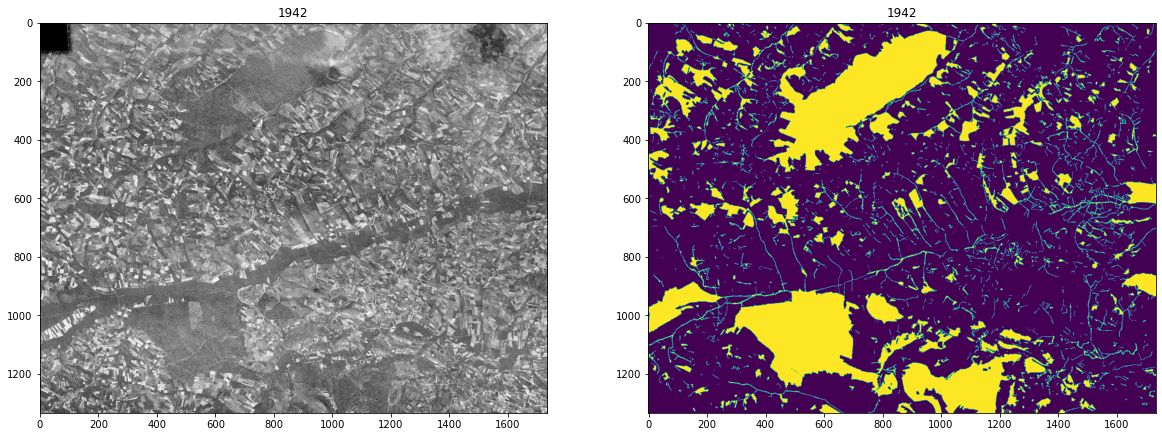

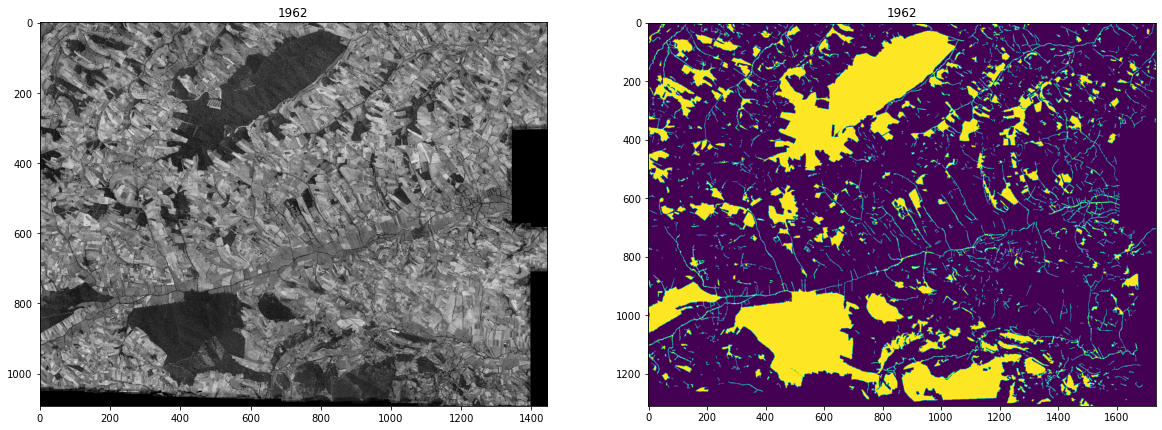

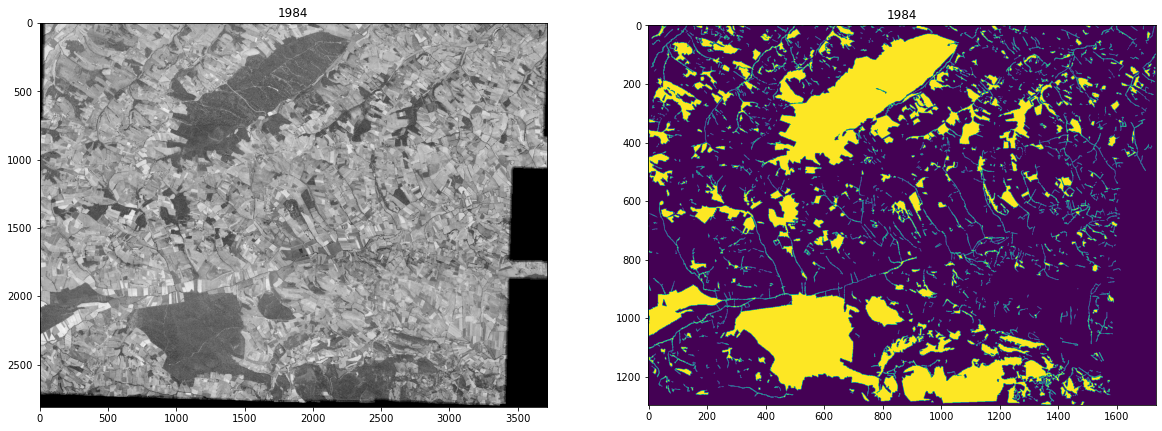

In [188]:
# Plot
def plot_comparison(img1, img2, title):
    n_col = 2
    _, axs = plt.subplots(1, n_col, figsize=(20, 20))
    
    axs[0].imshow(img1[::10,::10], cmap='gray')
    axs[0].set_title(title)
    axs[1].imshow(img2[::10,::10])
    axs[1].set_title(title)
    
    plt.show()

for year in imgs_dict.keys():
    plot_comparison(imgs_dict[year], masks_dic[year], year)


**Data Distribution**

In [207]:
# Calculates the average count of vegetation and non-vegetation layers 
counts = np.zeros((len(masks_dic), 2))

for i, year in enumerate(masks_dic.keys()):
    counts[i] = np.unique(masks_dic[year], return_counts=True)[1]

avg_counts = counts.mean(axis=0)
avg_counts

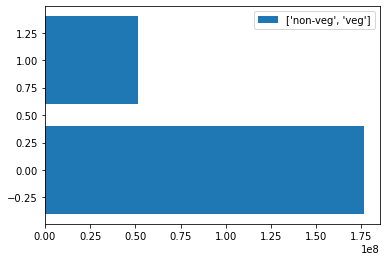

In [215]:
# plot # go plotly or SNS 
plt.barh([0, 1], avg_counts, label= ['non-veg', 'veg'])
plt.legend()

**Area by year**

In [257]:
GPKG_PATH = '..\data\mask_per_year.gpkg'
years = fiona.listlayers(GPKG_PATH)[1:] # list layers/years

# read the masks 
mask_per_year = {}
u_year = list(masks_dic.keys())
for year in years:
    if np.isin(year, u_year):
        mask_per_year.update({year: gpd.read_file(GPKG_PATH, layer= year)})

mask_per_year['1942'].head()

,ID,PREC_PLANI,NATURE,geometry
0,ZONEARBO0000000036808850,5.0,Zone arborÃ©e,"MULTIPOLYGON (((520864.372 6248151.085, 520866..."
1,ZONEARBO0000000036808850,5.0,Zone arborÃ©e,"MULTIPOLYGON (((519843.100 6246716.100, 519841..."
2,ZONEARBO0000000036808850,5.0,Zone arborÃ©e,"MULTIPOLYGON (((525365.487 6246165.322, 525403..."
3,ZONEARBO0000000036808850,5.0,Zone arborÃ©e,"MULTIPOLYGON (((529215.800 6239090.300, 529216..."
4,ZONEARBO0000000036808850,5.0,Zone arborÃ©e,"MULTIPOLYGON (((530338.900 6239116.900, 530343..."


In [279]:
# create a df with veg area by year
area_by_year = {year:np.sum(mask_per_year[year].area) for year in u_year}
df = pd.DataFrame.from_dict(area_by_year, orient='index', columns=['area']).reset_index()
df.rename(columns={'index': 'year'}, inplace=True)

<AxesSubplot:ylabel='year'>

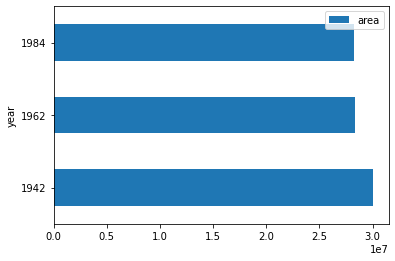

In [295]:
df.plot.barh(x = 'year', y='area')